# Multi-Class Classification on Students Performance Dataset

# Abstract

This project investigates the task of predicting student academic performance categories using supervised machine learning techniques. Multiple models—including Logistic Regression, Random Forest, XGBoost, and a Neural Network—are evaluated on a structured tabular dataset. To ensure robust and fair evaluation, class imbalance is addressed using class weighting, and performance is assessed using both accuracy and macro F1-score. Additionally, a feature leakage analysis is conducted by removing GPA-related features to study their impact on model generalization. Experimental results show that tree-based ensemble methods, particularly XGBoost, achieve the strongest overall performance on tabular data, while neural networks underperform due to limited dataset size and feature complexity. The findings highlight the importance of model selection, feature analysis, and evaluation metrics when working with imbalanced educational datasets.

# 1. Introduction

This notebook presents a complete machine learning workflow for a multi-class classification task using the **Students Performance Dataset** from Kaggle.  
The objective is to predict a student's **GradeClass** (A, B, C, D, or F) based on academic and behavioral features.

We evaluate and compare multiple models representing different machine learning paradigms:
- **Logistic Regression** (baseline linear model)
- **Random Forest** (tree-based ensemble)
- **XGBoost** (gradient boosting)
- **Neural Network** (deep learning using PyTorch)

The notebook follows best practices, including data preprocessing, model evaluation using multiple metrics, handling class imbalance, and feature analysis, making it suitable for academic study, Kaggle competitions, and portfolio projects.


# 2. Problem Definition

The task is a **multi-class classification problem**, where the goal is to predict a student's academic performance category (**GradeClass**) based on a set of input features.

- **Input**: Student-related features such as study habits, support indicators, and academic records  
- **Output**: A discrete grade category (A, B, C, D, or F)

Formally, given a feature vector \( X \), the objective is to learn a function \( f(X) \rightarrow Y \), where \( Y \) represents one of the five grade classes.

Challenges associated with this problem include:
- Class imbalance across grade categories
- Feature dominance (e.g., GPA strongly correlating with the target)
- Model selection for tabular data


# 3. Import Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# Will add this to create comprehensive visualizations

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# ============================================
# 1. MODEL COMPARISON BAR CHART
# ============================================
def plot_model_comparison(results):
    """Create a bar chart comparing model accuracies"""
    plt.figure(figsize=(10, 6))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
    bars = plt.bar(results['Model'], results['Accuracy'], color=colors, alpha=0.8, edgecolor='black')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.xlabel('Model', fontsize=12, fontweight='bold')
    plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
    plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
    plt.ylim(0, 1.0)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# ============================================
# 2. CONFUSION MATRICES FOR ALL MODELS
# ============================================
def plot_confusion_matrices(y_test, predictions_dict, class_names):
    """Plot confusion matrices for all models"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle('Confusion Matrices for All Models', fontsize=16, fontweight='bold')
    
    model_names = list(predictions_dict.keys())
    
    for idx, (ax, model_name) in enumerate(zip(axes.flatten(), model_names)):
        cm = confusion_matrix(y_test, predictions_dict[model_name])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=class_names, yticklabels=class_names,
                   cbar_kws={'label': 'Count'})
        ax.set_title(f'{model_name}', fontsize=12, fontweight='bold')
        ax.set_ylabel('True Label', fontsize=10)
        ax.set_xlabel('Predicted Label', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# ============================================
# 3. NEURAL NETWORK ARCHITECTURE DIAGRAM
# ============================================
def plot_nn_architecture_dynamic(model, input_dim):
    """
    Dynamically visualize a PyTorch feedforward neural network architecture
    """
    layers_info = []
    prev_dim = input_dim

    # Extract layer info
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            layers_info.append({
                "type": "Linear",
                "in": prev_dim,
                "out": layer.out_features
            })
            prev_dim = layer.out_features

        elif isinstance(layer, nn.ReLU):
            layers_info.append({"type": "ReLU"})

        elif isinstance(layer, nn.Dropout):
            layers_info.append({"type": f"Dropout (p={layer.p})"})

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis("off")

    y_positions = list(reversed([0.15 + i * 0.12 for i in range(len(layers_info))]))

    for i, (layer, y) in enumerate(zip(layers_info, y_positions)):
        if layer["type"] == "Linear":
            text = f"Linear\n{layer['in']} → {layer['out']}"
            color = "lightblue"
        else:
            text = layer["type"]
            color = "lightgray"

        # Draw box
        rect = plt.Rectangle((0.3, y - 0.04), 0.4, 0.08,
                             facecolor=color, edgecolor="black", linewidth=2)
        ax.add_patch(rect)

        ax.text(0.5, y, text,
                ha="center", va="center", fontsize=11, fontweight="bold")

        # Draw arrow
        if i < len(layers_info) - 1:
            ax.arrow(0.5, y - 0.04, 0, -0.06,
                     head_width=0.03, head_length=0.015,
                     fc="gray", ec="gray", linewidth=2)

    ax.set_title("Dynamic Neural Network Architecture", fontsize=16, fontweight="bold")
    plt.tight_layout()
    plt.show()

# ============================================
# 4. FEATURE IMPORTANCE (Random Forest & XGBoost)
# ============================================
def plot_feature_importance(model, feature_names, model_name, top_n=15):
    """Plot feature importance for tree-based models"""
    importances = model.feature_importances_
    indices = np.argsort(importances)[-top_n:]
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(indices)), importances[indices], color='teal', alpha=0.8)
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
    plt.title(f'Top {top_n} Features - {model_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# ============================================
# 5. TRAINING LOSS CURVE (for Neural Network)
# ============================================
def plot_training_curve(losses):
    """Plot training loss over epochs"""
    plt.figure(figsize=(10, 6))
    plt.plot(losses, linewidth=2, color='darkblue')
    plt.xlabel('Epoch', fontsize=12, fontweight='bold')
    plt.ylabel('Loss', fontsize=12, fontweight='bold')
    plt.title('Neural Network Training Loss', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ============================================
# 6. CLASS-WISE PERFORMANCE COMPARISON
# ============================================
def plot_classwise_performance(y_test, predictions_dict, class_names):
    """Compare per-class F1-scores across models"""
    from sklearn.metrics import f1_score
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(class_names))
    width = 0.2
    
    for idx, (model_name, y_pred) in enumerate(predictions_dict.items()):
        f1_scores = f1_score(y_test, y_pred, average=None)
        ax.bar(x + idx*width, f1_scores, width, label=model_name, alpha=0.8)
    
    ax.set_xlabel('Class', fontsize=12, fontweight='bold')
    ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    ax.set_title('Class-wise F1-Score Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(class_names)
    ax.legend(loc='lower right')
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# ============================================
# 7. TREE VISUALIZATION (Single Tree from RF)
# ============================================
def plot_single_tree(rf_model, feature_names, max_depth=3):
    """Visualize a single decision tree from Random Forest"""
    from sklearn.tree import plot_tree
    
    plt.figure(figsize=(20, 10))
    plot_tree(rf_model.estimators_[0], 
             feature_names=feature_names,
             class_names=['0', '1', '2', '3', '4'],
             filled=True,
             max_depth=max_depth,
             fontsize=10)
    plt.title(f'Sample Decision Tree from Random Forest (max_depth={max_depth})', 
             fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


# 4. Load Dataset

In [3]:
df = pd.read_csv('Student_performance_data _.csv')
df.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


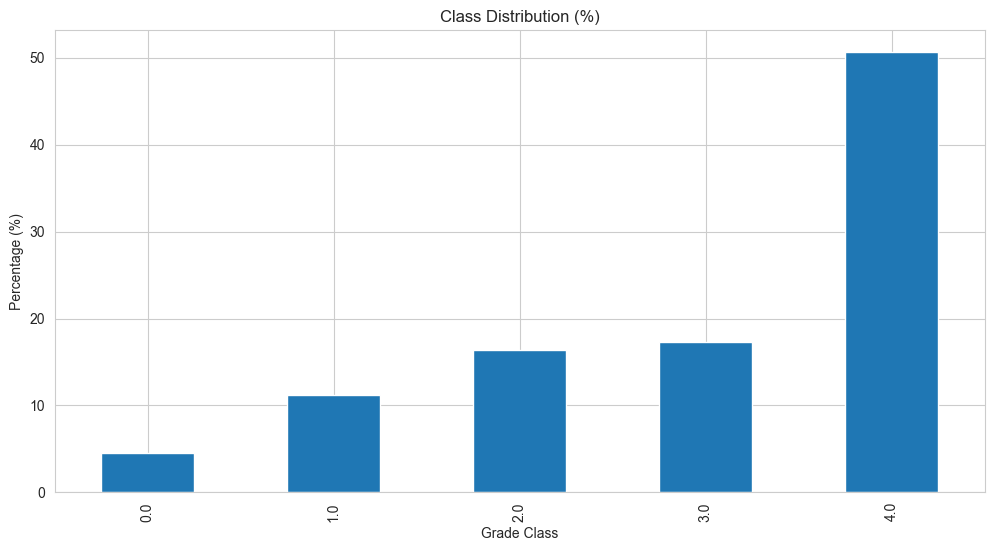

In [4]:
class_percent = df['GradeClass'].value_counts(normalize=True).sort_index() * 100

plt.figure()
class_percent.plot(kind='bar')
plt.ylabel('Percentage (%)')
plt.xlabel('Grade Class')
plt.title('Class Distribution (%)')
plt.show()

# 5. Data Preprocessing
Before training the models, several preprocessing steps were applied to ensure data quality, consistency, and fair model evaluation.

First, the dataset was inspected for missing values and data types. All features were confirmed to be complete and suitable for numerical modeling. Categorical variables, where present, were encoded into numerical representations to make them compatible with machine learning algorithms.

Next, the target variable **GradeClass** was treated as a multi-class label representing student performance levels (e.g., A, B, C, D, F). The dataset was then split into training and testing sets to allow unbiased evaluation of model performance on unseen data.

Feature scaling was applied **only to models that are sensitive to feature magnitude**, specifically Logistic Regression and the Neural Network. Standardization was performed to ensure that all input features contribute equally during optimization. Tree-based models (Random Forest and XGBoost) were trained on the original feature scales, as they are inherently scale-invariant.

Finally, class distribution was analyzed and found to be imbalanced. This imbalance was addressed in later stages through the use of class-weighted loss functions and evaluation metrics beyond simple accuracy.

In [5]:
# Target and features
y = df['GradeClass']
X = df.drop(columns=['GradeClass', 'StudentID'])

# Encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


# 6. Feature Scaling (for LR & NN)
> For Logistic Regression & Neural Network

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# 7. Model 1: Logistic Regression (Baseline)



In [7]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

y_pred_lr = logreg.predict(X_test_scaled)
print('Logistic Regression Accuracy:', accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.8016701461377871
              precision    recall  f1-score   support

           0       0.40      0.19      0.26        21
           1       0.63      0.54      0.58        54
           2       0.64      0.78      0.70        78
           3       0.79      0.65      0.72        83
           4       0.91      0.97      0.94       243

    accuracy                           0.80       479
   macro avg       0.67      0.63      0.64       479
weighted avg       0.79      0.80      0.79       479



# 8. Model 2: Random Forest

In [8]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print('Random Forest Accuracy:', accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.9102296450939458
              precision    recall  f1-score   support

           0       1.00      0.29      0.44        21
           1       0.82      0.85      0.84        54
           2       0.89      0.95      0.92        78
           3       0.89      0.89      0.89        83
           4       0.94      0.97      0.96       243

    accuracy                           0.91       479
   macro avg       0.91      0.79      0.81       479
weighted avg       0.91      0.91      0.90       479



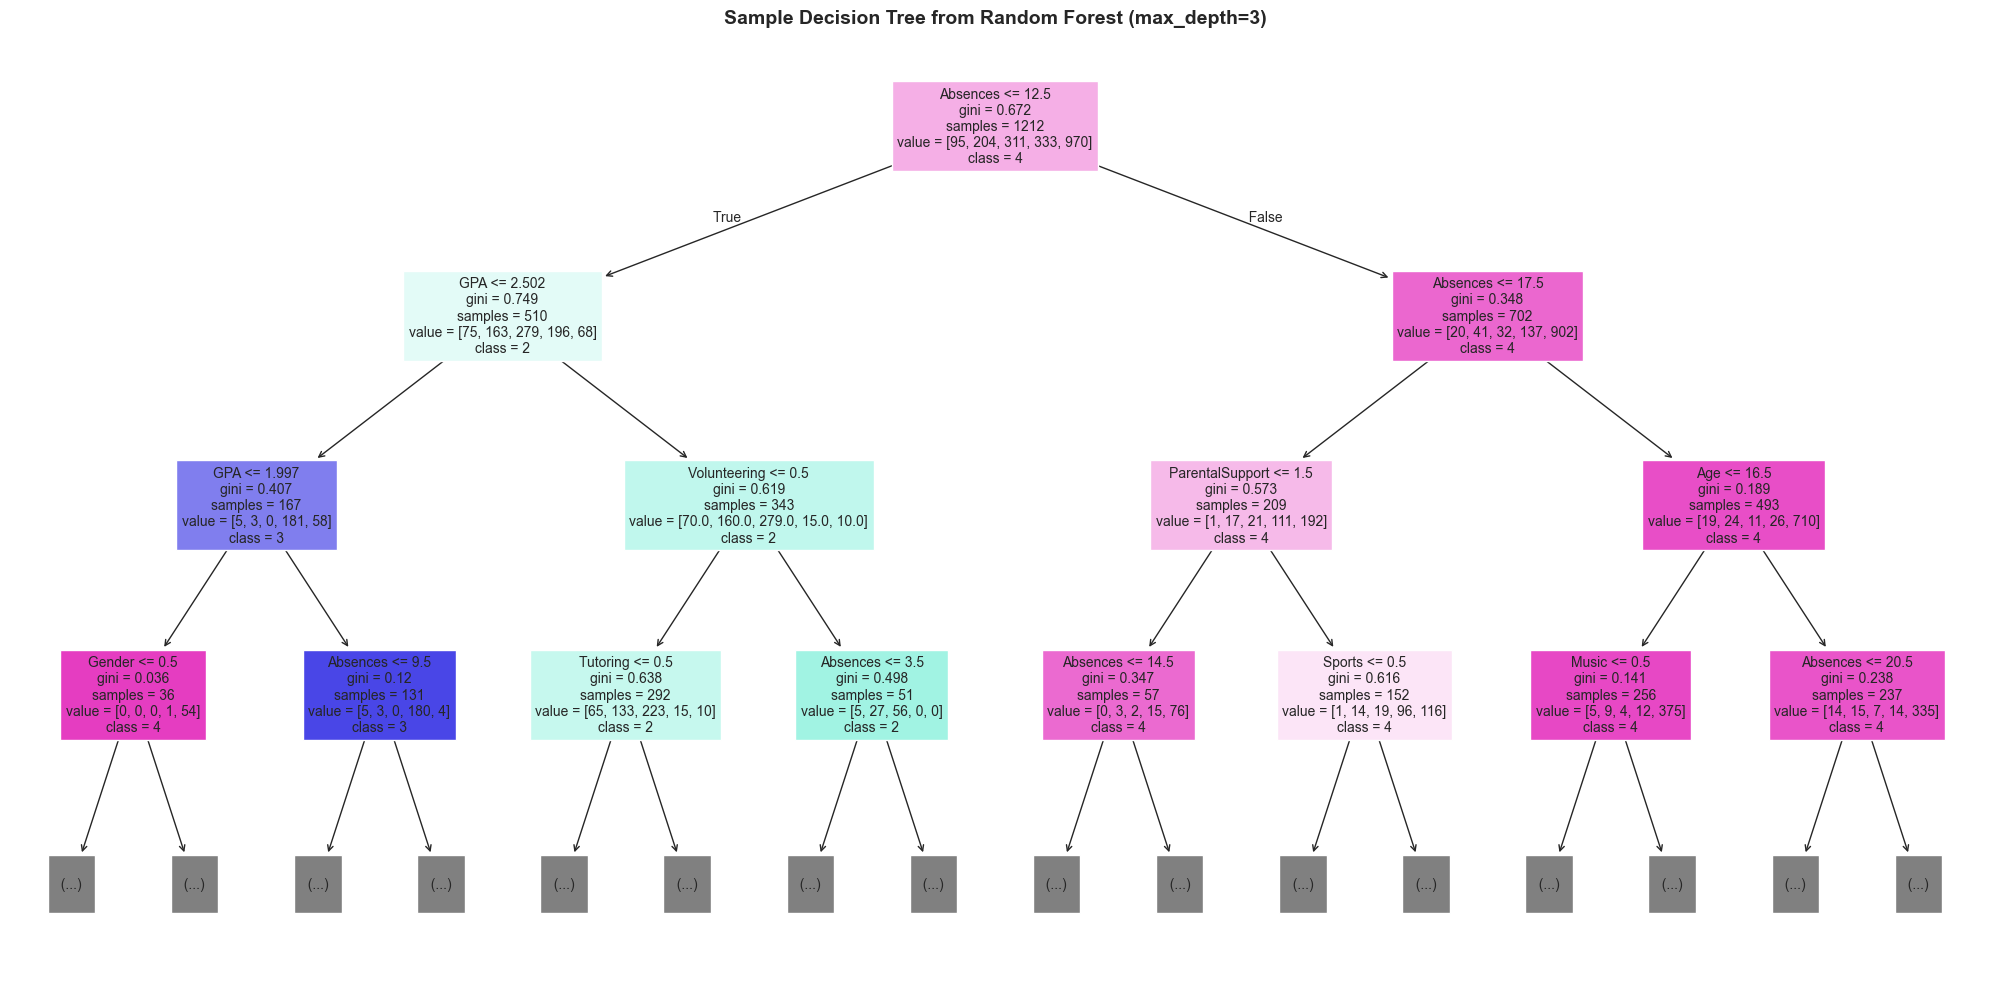

In [9]:
#  Single tree visualization
plot_single_tree(rf, X.columns, max_depth=3)

# 9. Model 3: XGBoost

In [10]:
xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y_train)),
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    random_state=42
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
print('XGBoost Accuracy:', accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 0.9206680584551148
              precision    recall  f1-score   support

           0       1.00      0.48      0.65        21
           1       0.89      0.91      0.90        54
           2       0.93      0.95      0.94        78
           3       0.89      0.87      0.88        83
           4       0.93      0.97      0.95       243

    accuracy                           0.92       479
   macro avg       0.93      0.83      0.86       479
weighted avg       0.92      0.92      0.92       479



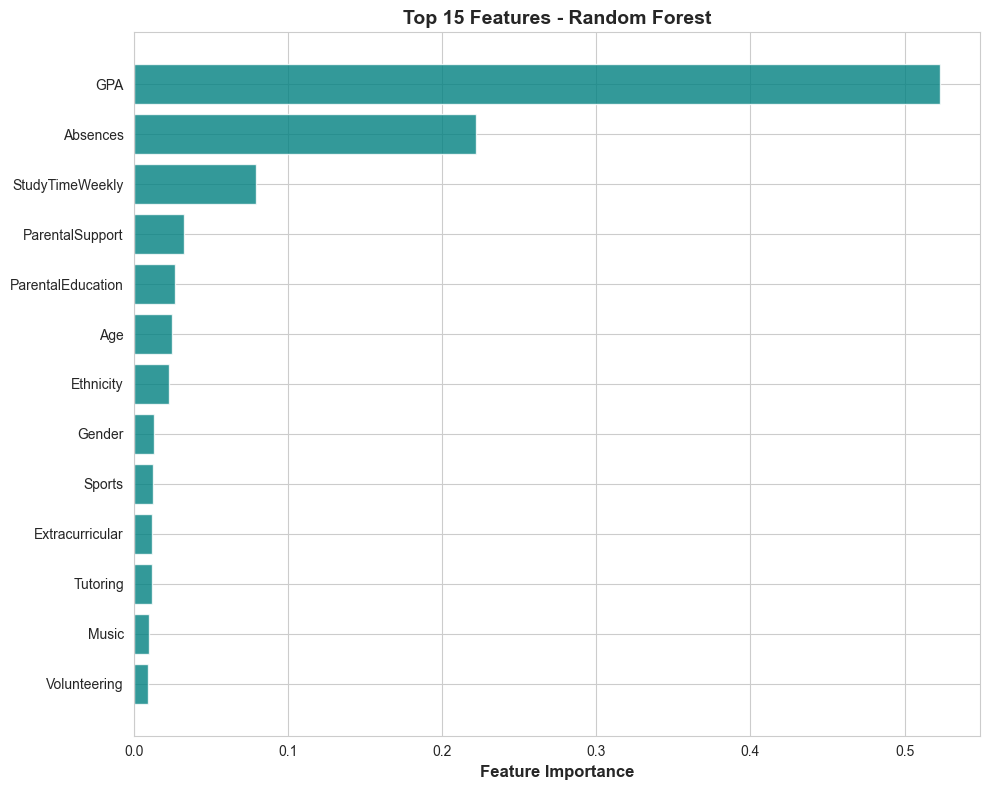

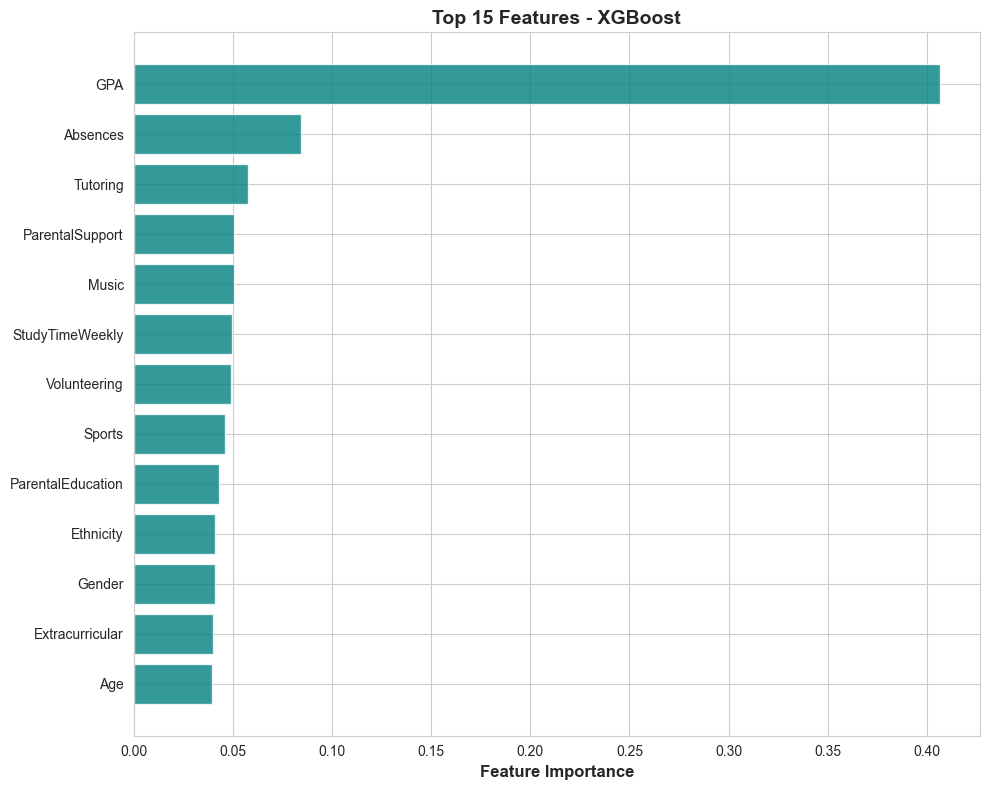

In [11]:
#  Feature importance
plot_feature_importance(rf, X.columns, 'Random Forest')
plot_feature_importance(xgb, X.columns, 'XGBoost')

# 10. Model 4: Neural Network (PyTorch)
> The neural network is included to explore deep learning applicability; however, its performance is constrained by dataset size and feature richness, which favors tree-based models.

In [12]:
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_test_t = torch.tensor(y_test, dtype=torch.long)

class StudentNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = StudentNN(X_train.shape[1], len(np.unique(y_train)))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with loss tracking
losses = []  
for epoch in range(50):
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    losses.append(loss.item())  # Store loss value
    loss.backward()
    optimizer.step()

with torch.no_grad():
    preds = torch.argmax(model(X_test_t), dim=1)
    acc = (preds == y_test_t).float().mean()

print('Neural Network Accuracy:', acc.item())


Neural Network Accuracy: 0.5908141732215881


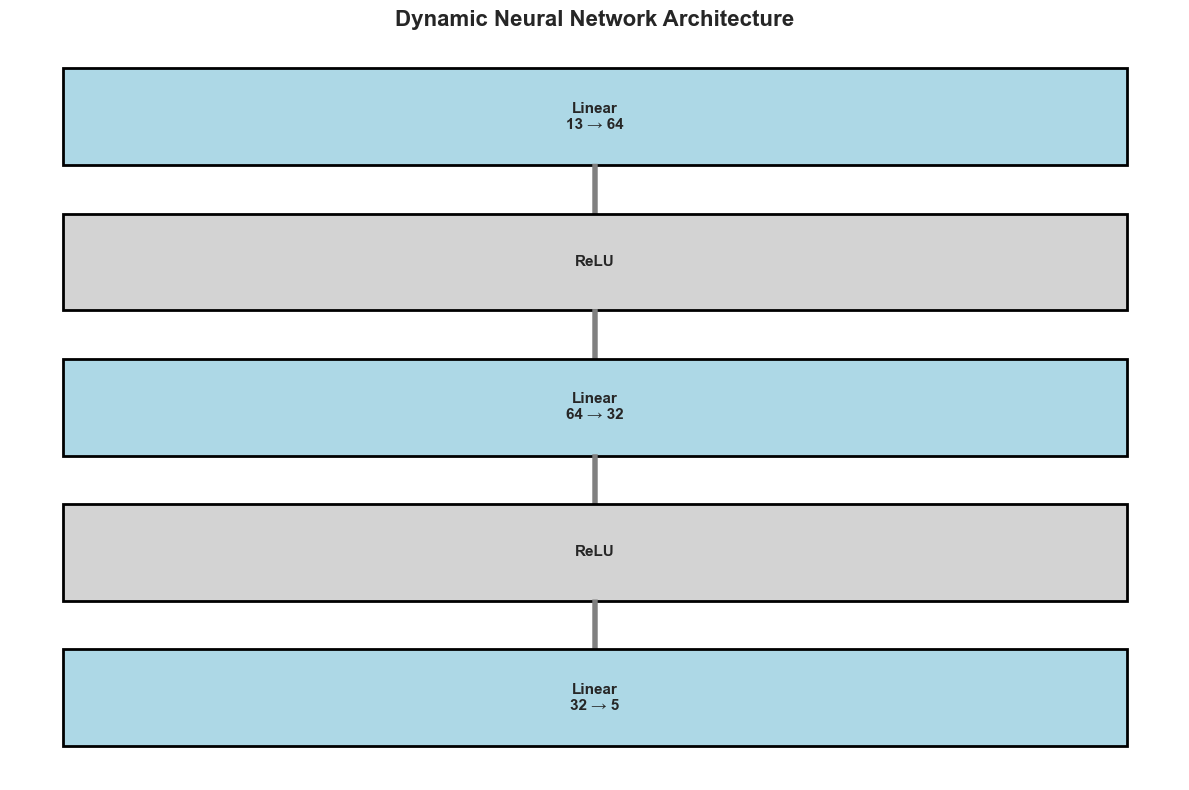

In [13]:
#  Neural network architecture
plot_nn_architecture_dynamic(model, input_dim=X_train.shape[1])


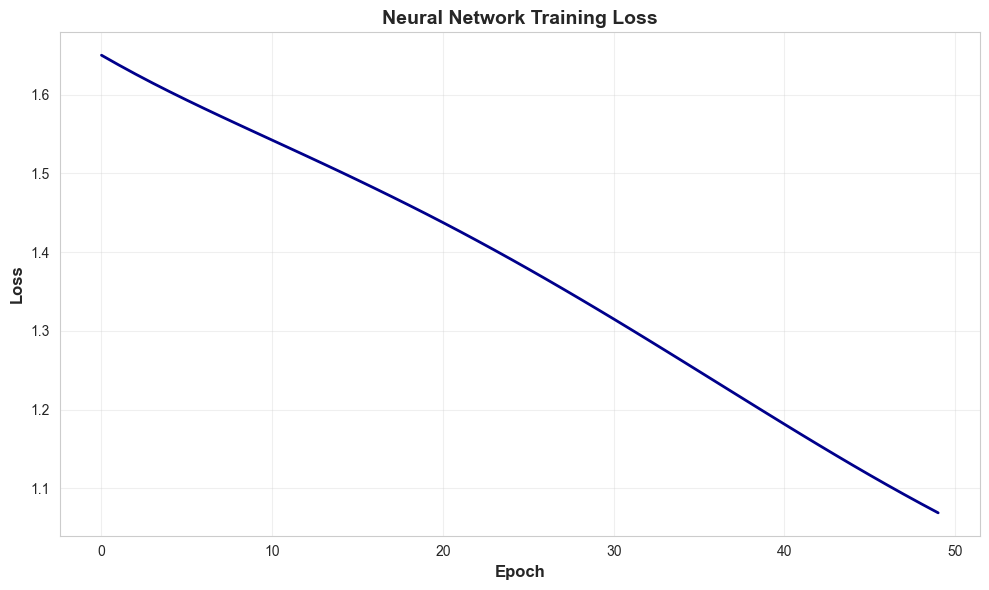

In [14]:
#  Training curve (modify NN training loop to collect losses)
plot_training_curve(losses)

# 11. Model Comparison

In [15]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'Neural Network'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb),
        acc.item()
    ]
})
results


,Model,Accuracy
0,Logistic Regression,0.801670
1,Random Forest,0.910230
2,XGBoost,0.920668
3,Neural Network,0.590814


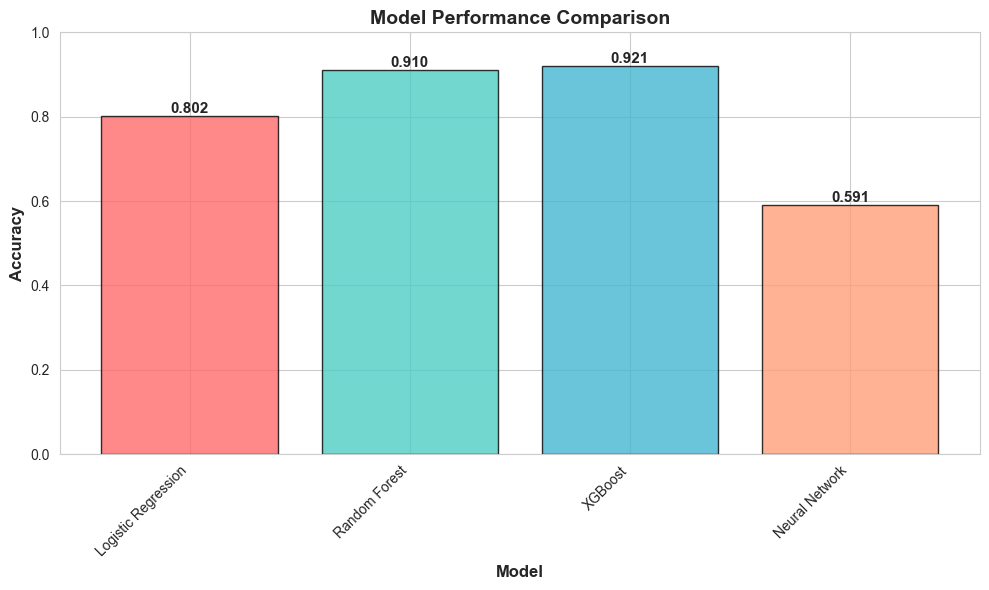

In [16]:
# 1. Model comparison
plot_model_comparison(results)

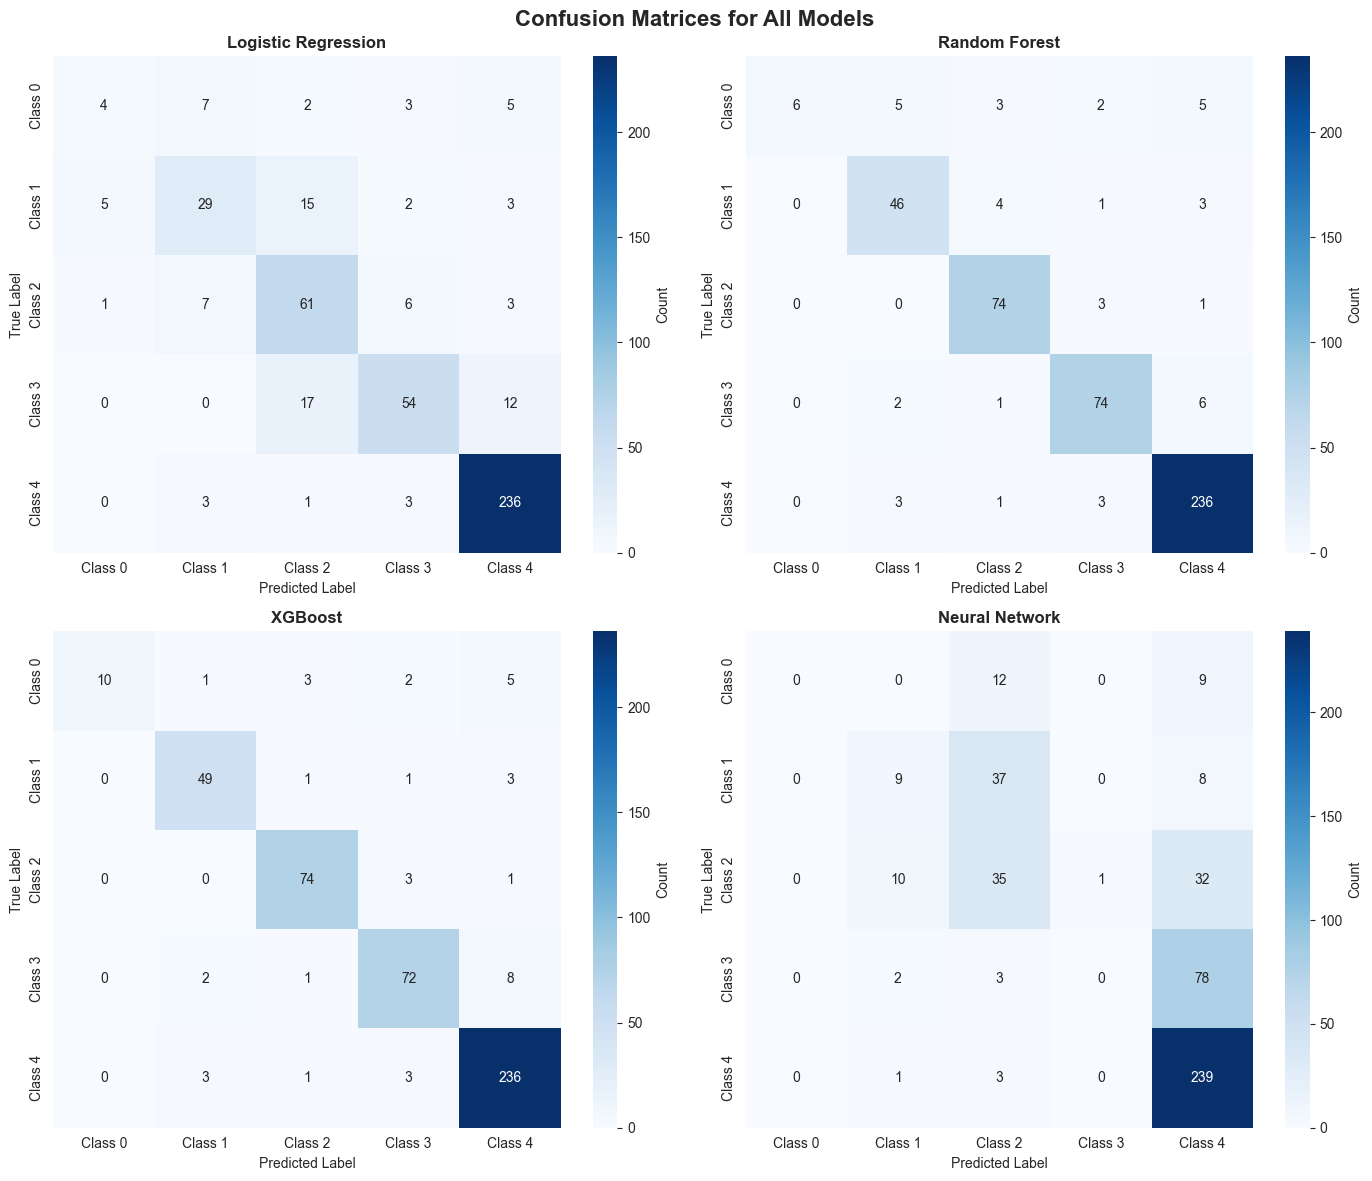

In [17]:
# 2. Confusion matrices
predictions_dict = {
    'Logistic Regression': y_pred_lr,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb,
    'Neural Network': preds.numpy()
}
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']
plot_confusion_matrices(y_test, predictions_dict, class_names)

> Due to class imbalance, macro F1-score is considered more informative than accuracy

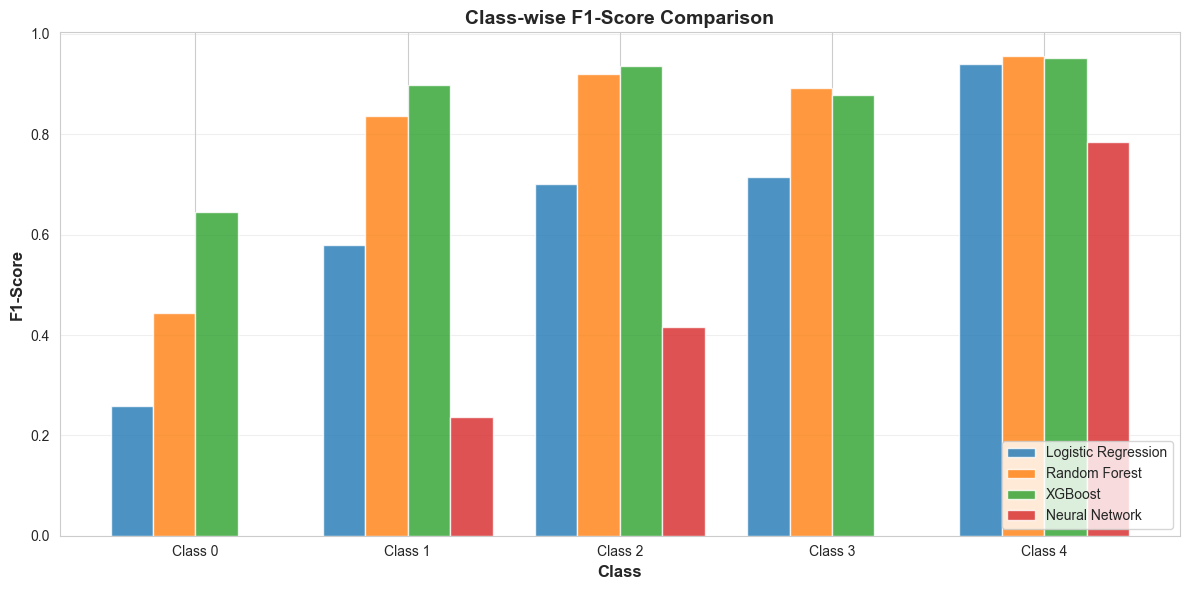

In [18]:
# 3. Class-wise performance
plot_classwise_performance(y_test, predictions_dict, class_names)

# 12. Handling Class Imbalance

The target variable (**GradeClass**) is not evenly distributed across classes, which can bias models toward majority classes and lead to misleading accuracy scores.

To address this issue:
- Class distributions were analyzed using class-wise metrics
- **Class weights** were applied during Neural Network training using a weighted cross-entropy loss
- Model performance was evaluated using **macro-averaged F1-score** in addition to accuracy

This approach ensures that minority classes (e.g., low-performing or high-performing students) are given appropriate importance during training, leading to more balanced and fair predictions.


In [19]:
# Step 1: Compute class weights 
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

classes = np.unique(y_train)
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

class_weights = torch.tensor(weights, dtype=torch.float32)

# Try old code considering class weights 
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_test_t = torch.tensor(y_test, dtype=torch.long)

class StudentNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = StudentNN(X_train.shape[1], len(np.unique(y_train)))
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with loss tracking
losses = []  
for epoch in range(50):
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    losses.append(loss.item())  # Store loss value
    loss.backward()
    optimizer.step()

with torch.no_grad():
    preds = torch.argmax(model(X_test_t), dim=1)
    acc = (preds == y_test_t).float().mean()

print('Neural Network Accuracy:', acc.item())

Neural Network Accuracy: 0.699373722076416


In [20]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'Neural Network'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb),
        acc.item()
    ]
})
results


,Model,Accuracy
0,Logistic Regression,0.801670
1,Random Forest,0.910230
2,XGBoost,0.920668
3,Neural Network,0.699374


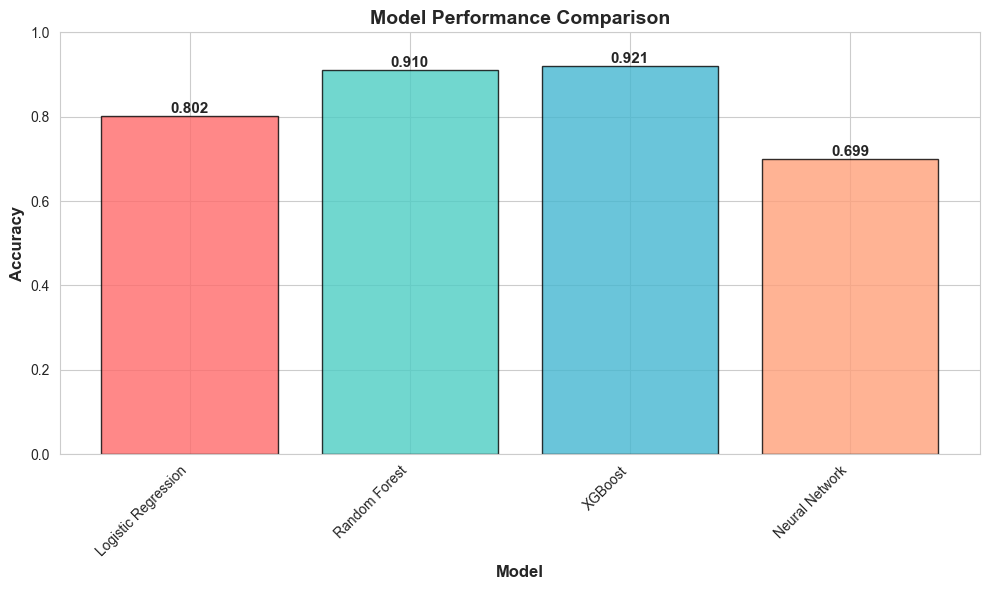

In [21]:
# 1.New Model comparison
plot_model_comparison(results)

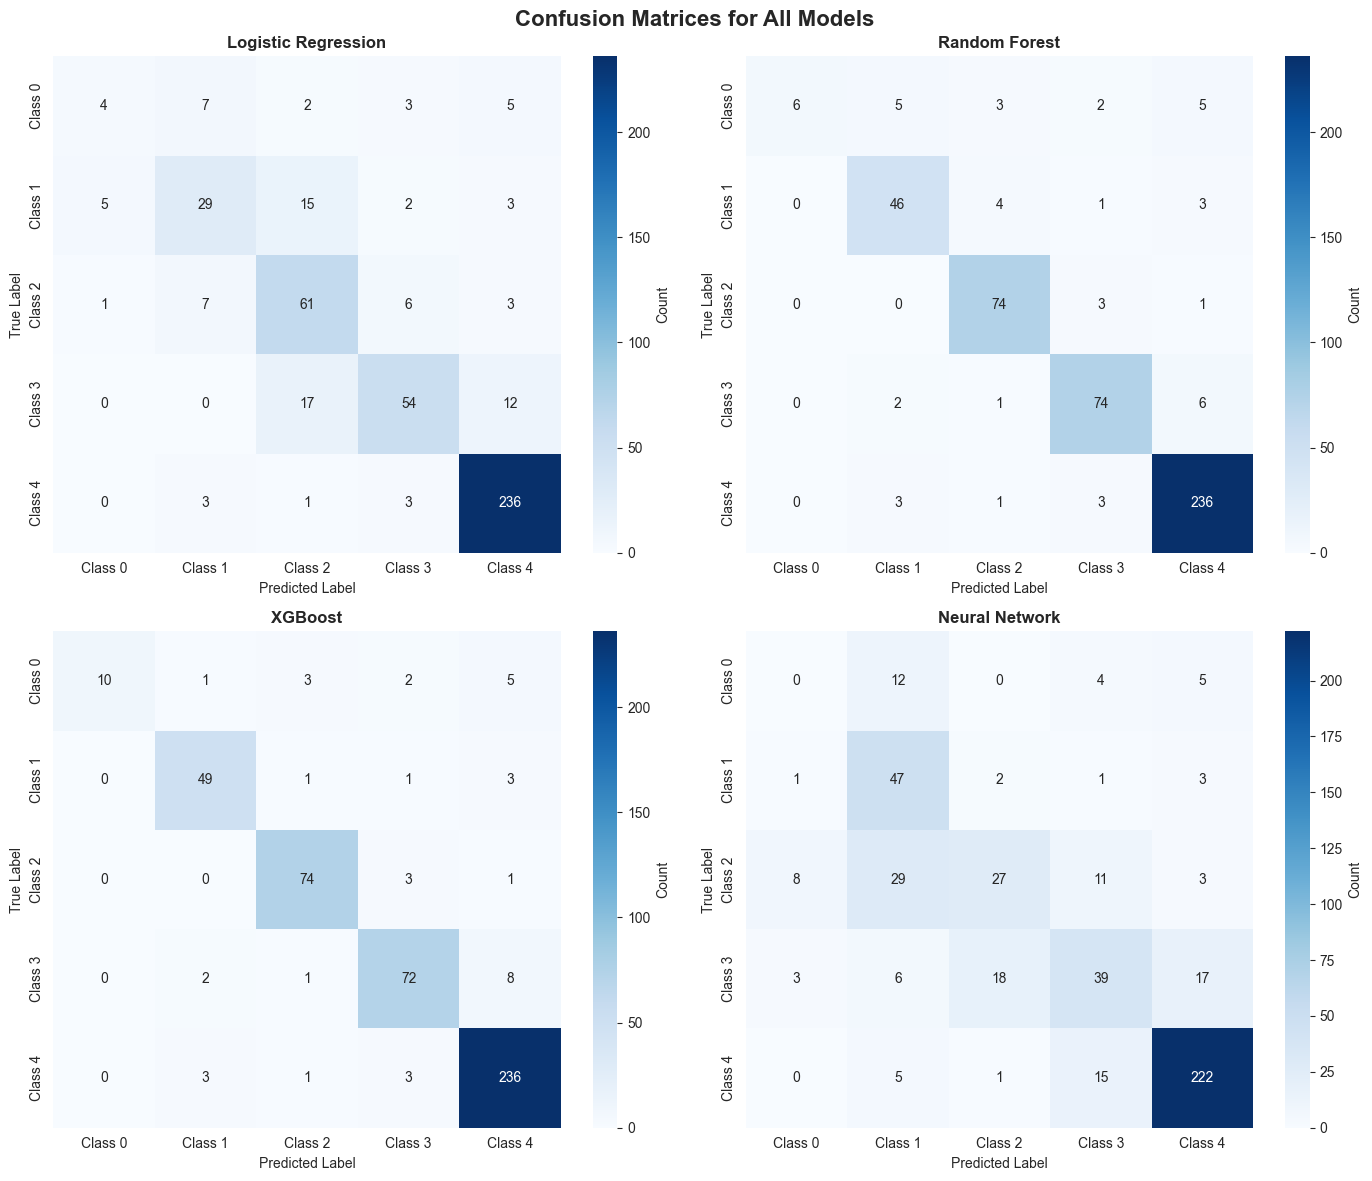

In [22]:
# 2. New confusion matrices
predictions_dict = {
    'Logistic Regression': y_pred_lr,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb,
    'Neural Network': preds.numpy()
}
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']
plot_confusion_matrices(y_test, predictions_dict, class_names)

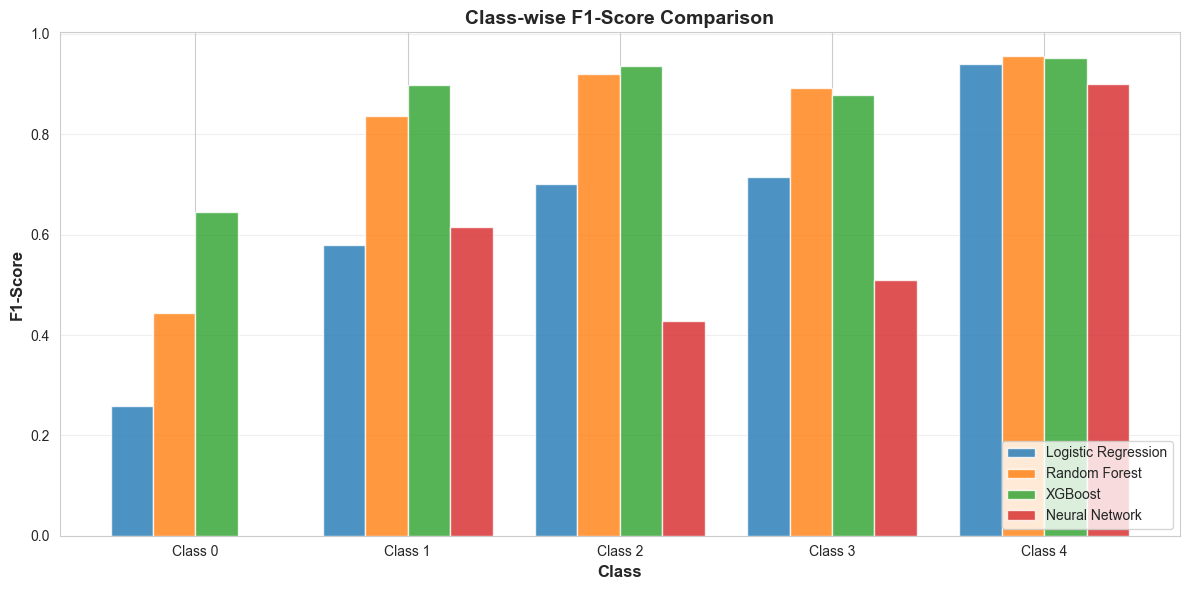

In [23]:
# 3. Class-wise performance
plot_classwise_performance(y_test, predictions_dict, class_names)

# 13. Neural Network Tuning
After establishing a baseline neural network model, several tuning strategies were applied to improve its performance and robustness. Initial results showed that the neural network underperformed compared to tree-based models, which is a common behavior for tabular datasets.

To address this, the network architecture was adjusted by increasing model capacity through additional neurons and deeper hidden layers. Regularization techniques such as **Dropout** were introduced to reduce overfitting and improve generalization on unseen data. The optimizer was also upgraded from Adam to **AdamW**, which incorporates weight decay and provides better control over model complexity.

Additionally, the dataset exhibited class imbalance across grade categories. To mitigate bias toward majority classes, **class-weighted cross-entropy loss** was employed. This approach assigns higher penalty to misclassification of underrepresented classes, leading to improved per-class recall and F1-score, particularly for minority grade categories.

Despite these improvements, the neural network still did not surpass tree-based ensemble methods in overall accuracy. However, its performance became more balanced across classes, demonstrating the effectiveness of tuning and proper loss weighting. This highlights both the strengths and limitations of neural networks when applied to structured tabular data.

In [24]:
# Step 1: Compute class weights
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

classes = np.unique(y_train)
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

class_weights = torch.tensor(weights, dtype=torch.float32)

# Try old code considering class weights and try tuning the NN Params#
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_test_t = torch.tensor(y_test, dtype=torch.long)

class StudentNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.09),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.09),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = StudentNN(X_train.shape[1], len(np.unique(y_train)))
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)


# Training loop with loss tracking
losses = []  
for epoch in range(150):
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    losses.append(loss.item())  # Store loss value
    loss.backward()
    optimizer.step()

with torch.no_grad():
    preds = torch.argmax(model(X_test_t), dim=1)
    acc = (preds == y_test_t).float().mean()

print('Neural Network Accuracy:', acc.item())



Neural Network Accuracy: 0.6847599148750305


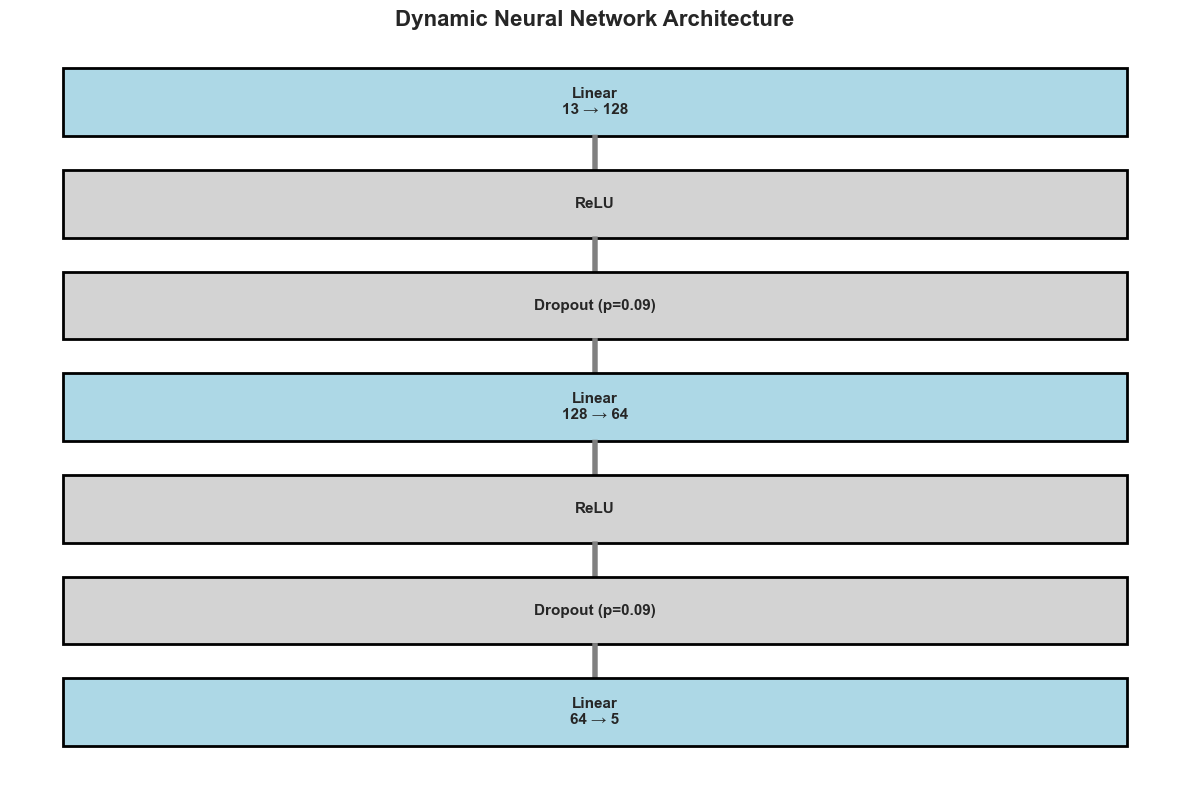

In [25]:
# 3. Neural network architecture
plot_nn_architecture_dynamic(model, input_dim=X_train.shape[1])

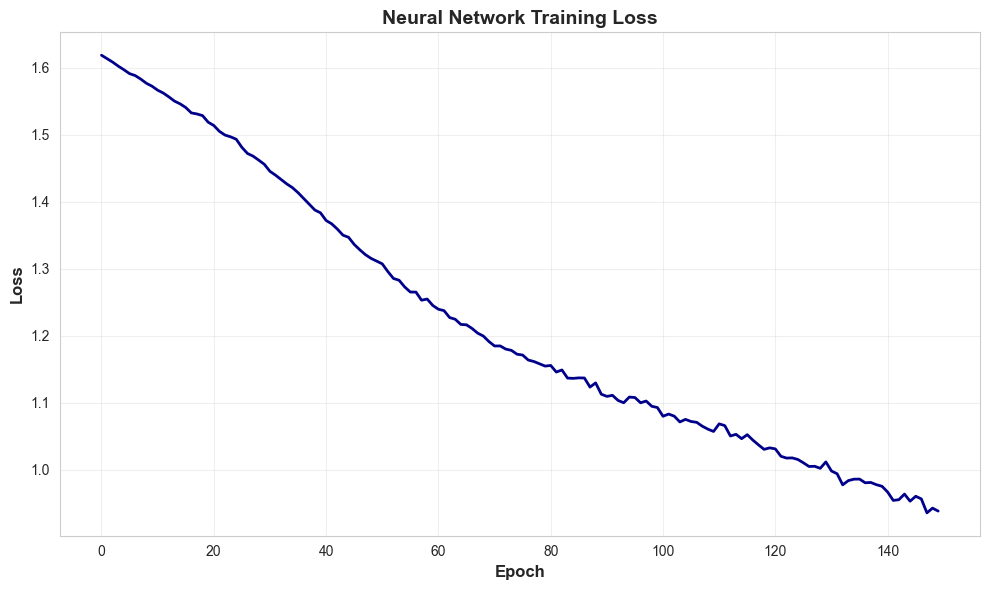

In [26]:
# 5. Training curve (modify NN training loop to collect losses)
plot_training_curve(losses)

In [27]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'Neural Network'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb),
        acc.item()
    ]
})
results


,Model,Accuracy
0,Logistic Regression,0.801670
1,Random Forest,0.910230
2,XGBoost,0.920668
3,Neural Network,0.684760


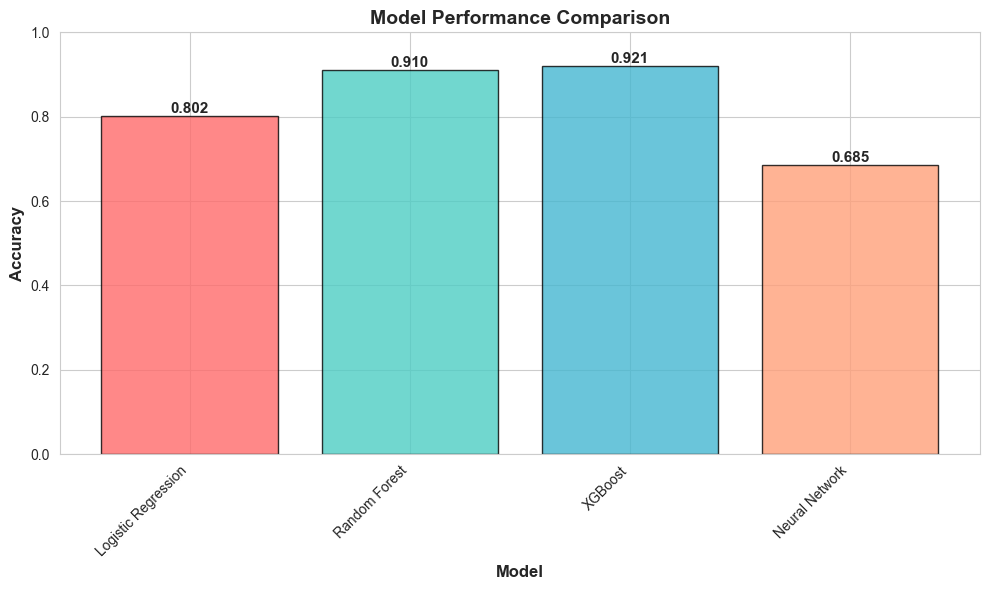

In [28]:
# 1.New Model comparison
plot_model_comparison(results)

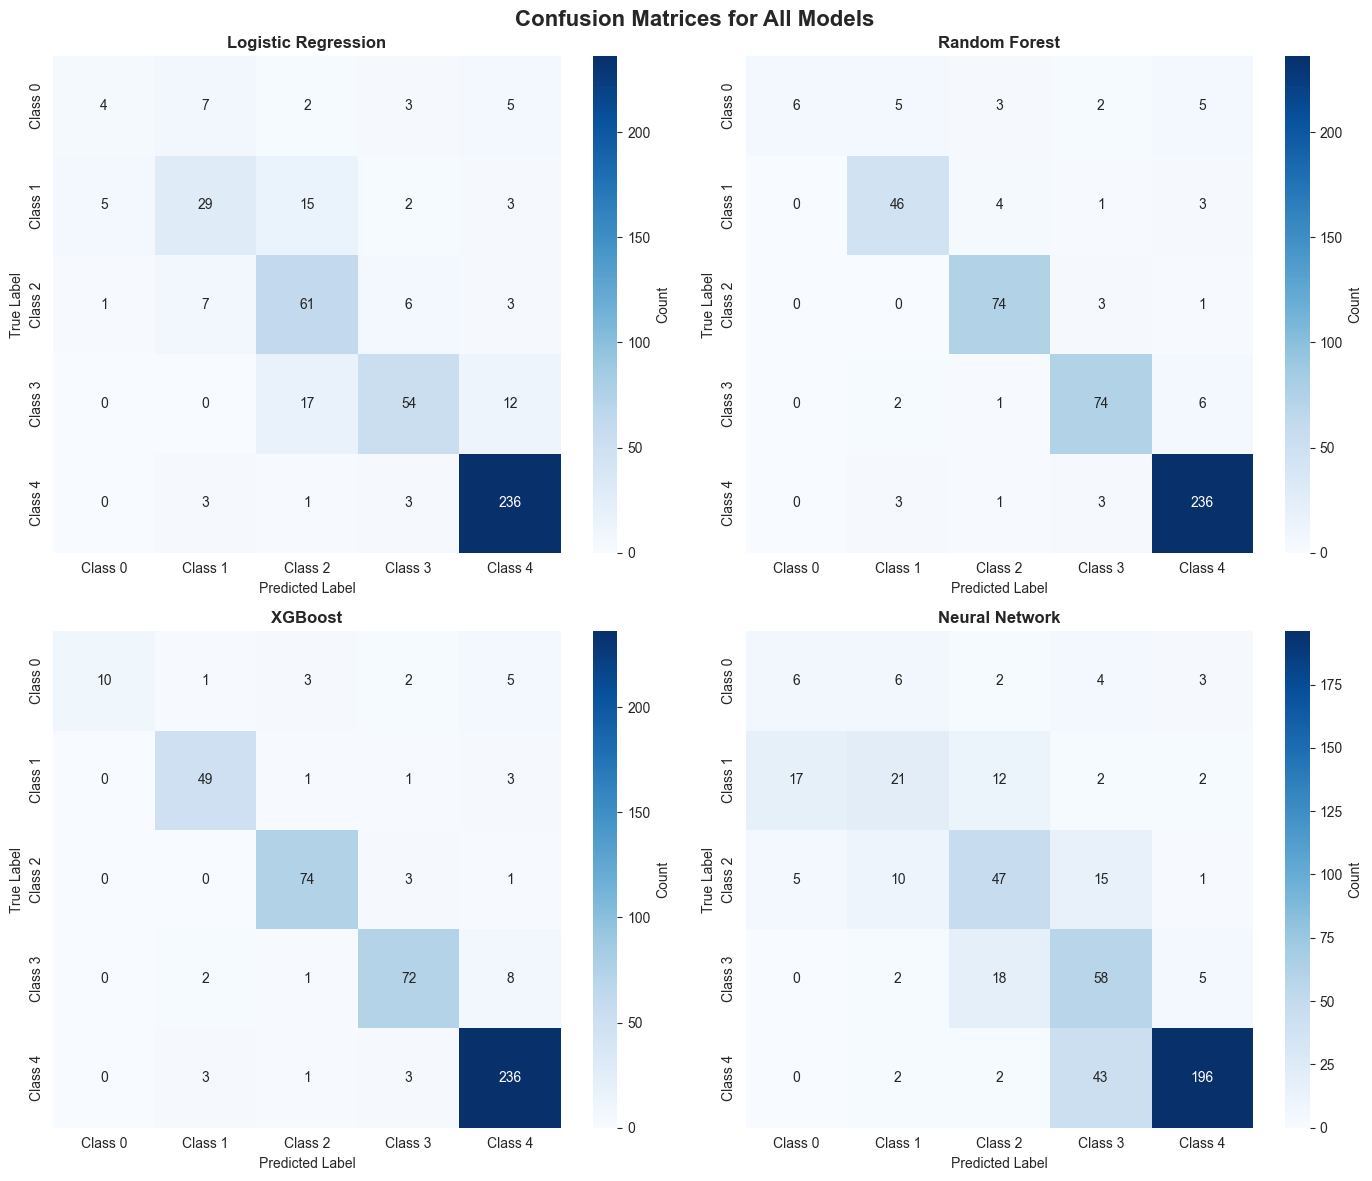

In [29]:
# 2. New confusion matrices
predictions_dict = {
    'Logistic Regression': y_pred_lr,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb,
    'Neural Network': preds.numpy()
}
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']
plot_confusion_matrices(y_test, predictions_dict, class_names)

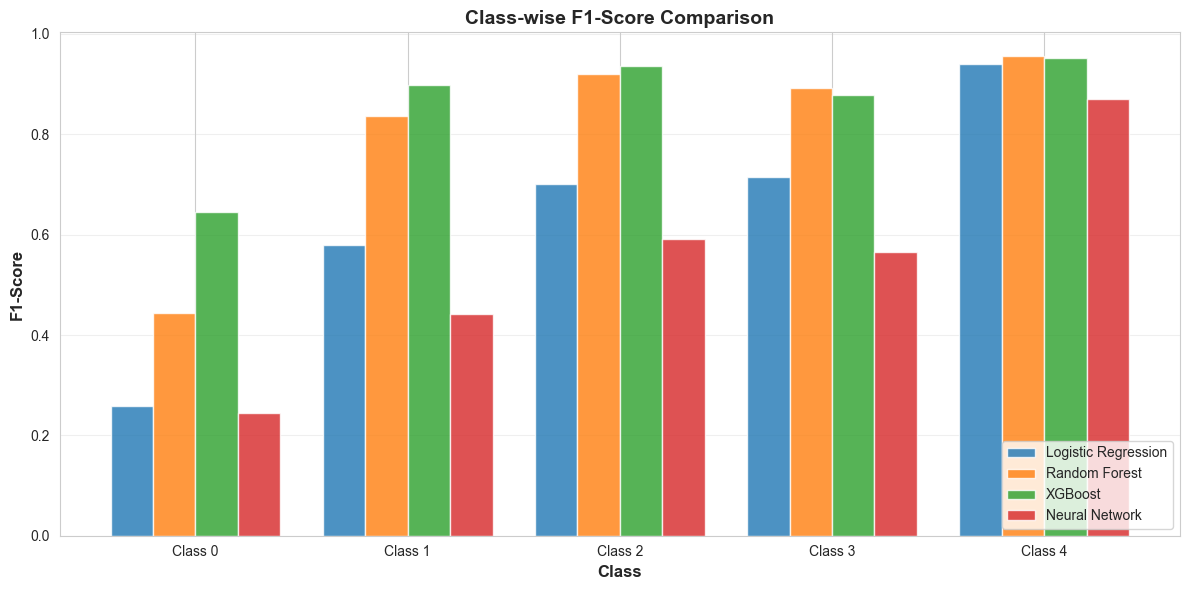

In [30]:
# 3. Class-wise performance
plot_classwise_performance(y_test, predictions_dict, class_names)

# 14. Feature Leakage Analysis (Removing GPA)

## Motivation for Removing GPA Feature

GPA is a strong indicator of academic performance and is often closely correlated with the target variable (**GradeClass**).  
Including GPA may lead to **feature leakage**, where the model relies heavily on this feature instead of learning meaningful patterns from behavioral and support-related inputs.

To investigate this effect:
- GPA was removed from the input features
- All models were retrained and re-evaluated
- Performance degradation was analyzed

This experiment aims to assess whether the models can predict student performance based on **behavioral factors** (such as study time and support systems) rather than relying on a near-direct proxy of the target.


In [31]:
# Target and features
y = df['GradeClass']
X = df.drop(columns=['GradeClass', 'GPA', 'StudentID'])

# Encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#6. Model 1: Logistic Regression (Baseline)
logreg = LogisticRegression( max_iter=1000)
logreg.fit(X_train_scaled, y_train)

y_pred_lr = logreg.predict(X_test_scaled)
#print('Logistic Regression Accuracy:', accuracy_score(y_test, y_pred_lr))
#print(classification_report(y_test, y_pred_lr))

#7. Model 2: Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
#print('Random Forest Accuracy:', accuracy_score(y_test, y_pred_rf))
#print(classification_report(y_test, y_pred_rf))

#8. Model 3: XGBoost
xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y_train)),
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    random_state=42
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
#print('XGBoost Accuracy:', accuracy_score(y_test, y_pred_xgb))
#print(classification_report(y_test, y_pred_xgb))

#NN
classes = np.unique(y_train)
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

class_weights = torch.tensor(weights, dtype=torch.float32)

# Try old code considering class weights and try tuning the NN Params#
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_test_t = torch.tensor(y_test, dtype=torch.long)

class StudentNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.09),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.09),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = StudentNN(X_train.shape[1], len(np.unique(y_train)))
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)


# Training loop with loss tracking
losses = []  
for epoch in range(150):
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    losses.append(loss.item())  # Store loss value
    loss.backward()
    optimizer.step()

with torch.no_grad():
    preds = torch.argmax(model(X_test_t), dim=1)
    acc = (preds == y_test_t).float().mean()

#print('Neural Network Accuracy:', acc.item())

In [32]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'Neural Network'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb),
        acc.item()
    ]
})
results

,Model,Accuracy
0,Logistic Regression,0.726514
1,Random Forest,0.713987
2,XGBoost,0.686848
3,Neural Network,0.613779


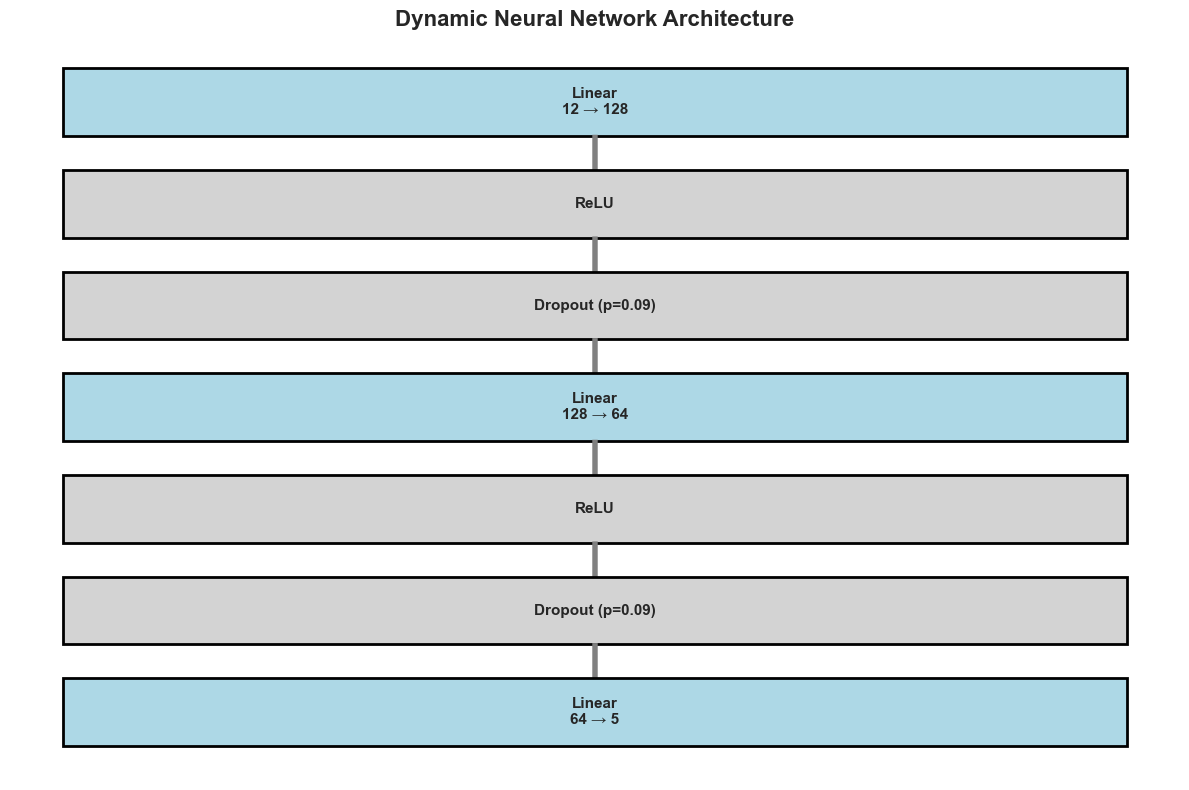

In [33]:
#  Neural network architecture
plot_nn_architecture_dynamic(model, input_dim=X_train.shape[1])

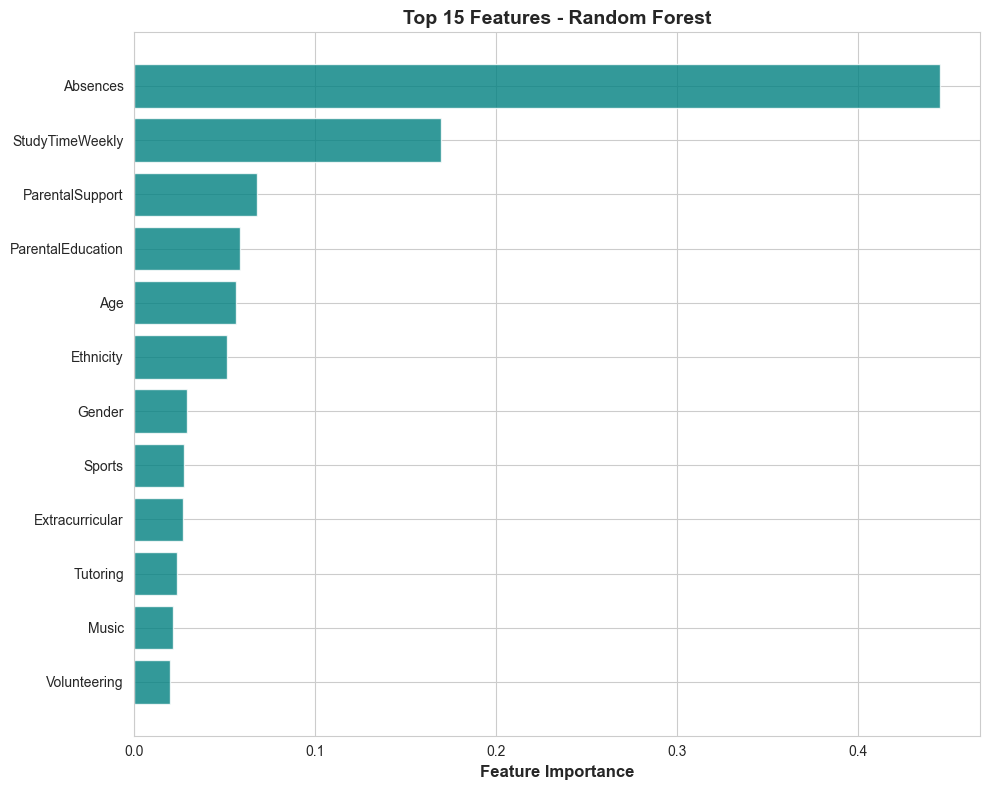

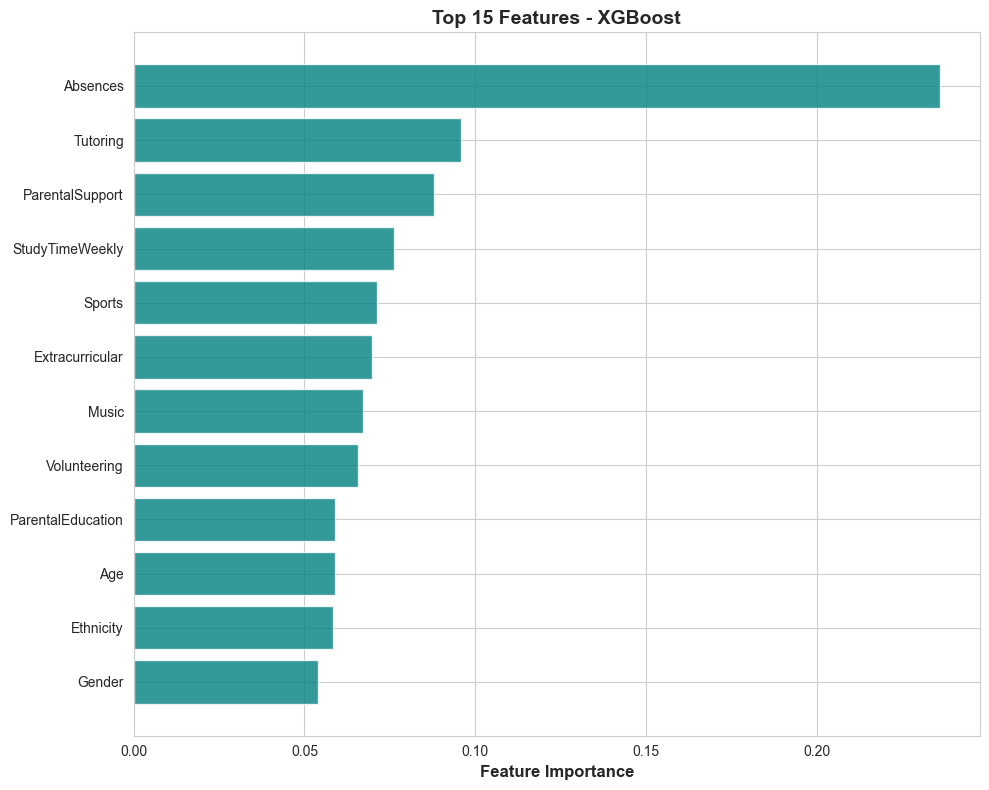

In [34]:
#  Feature importance
plot_feature_importance(rf, X.columns, 'Random Forest')
plot_feature_importance(xgb, X.columns, 'XGBoost')

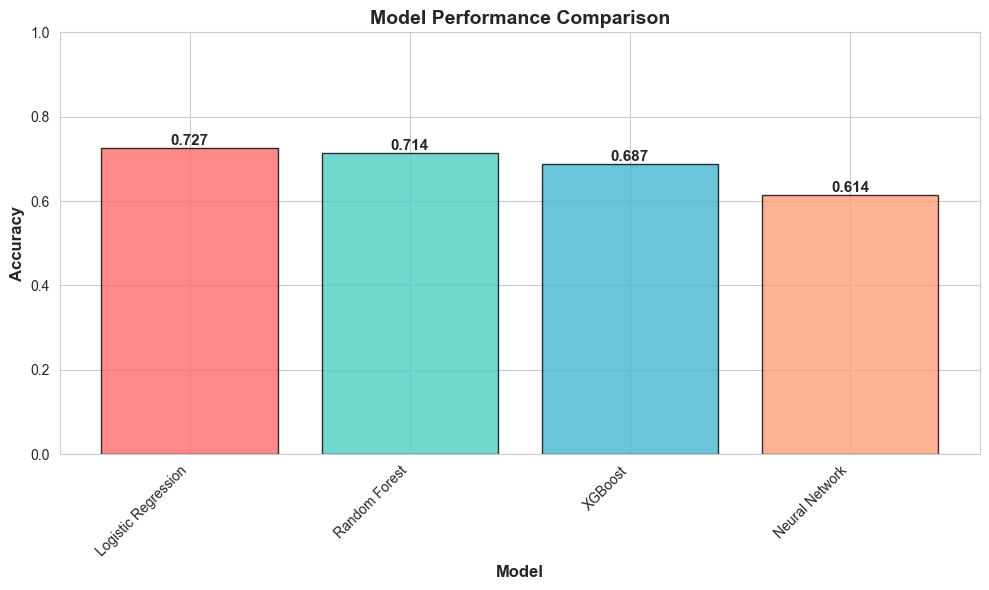

In [35]:
# 1.New Model comparison
plot_model_comparison(results)

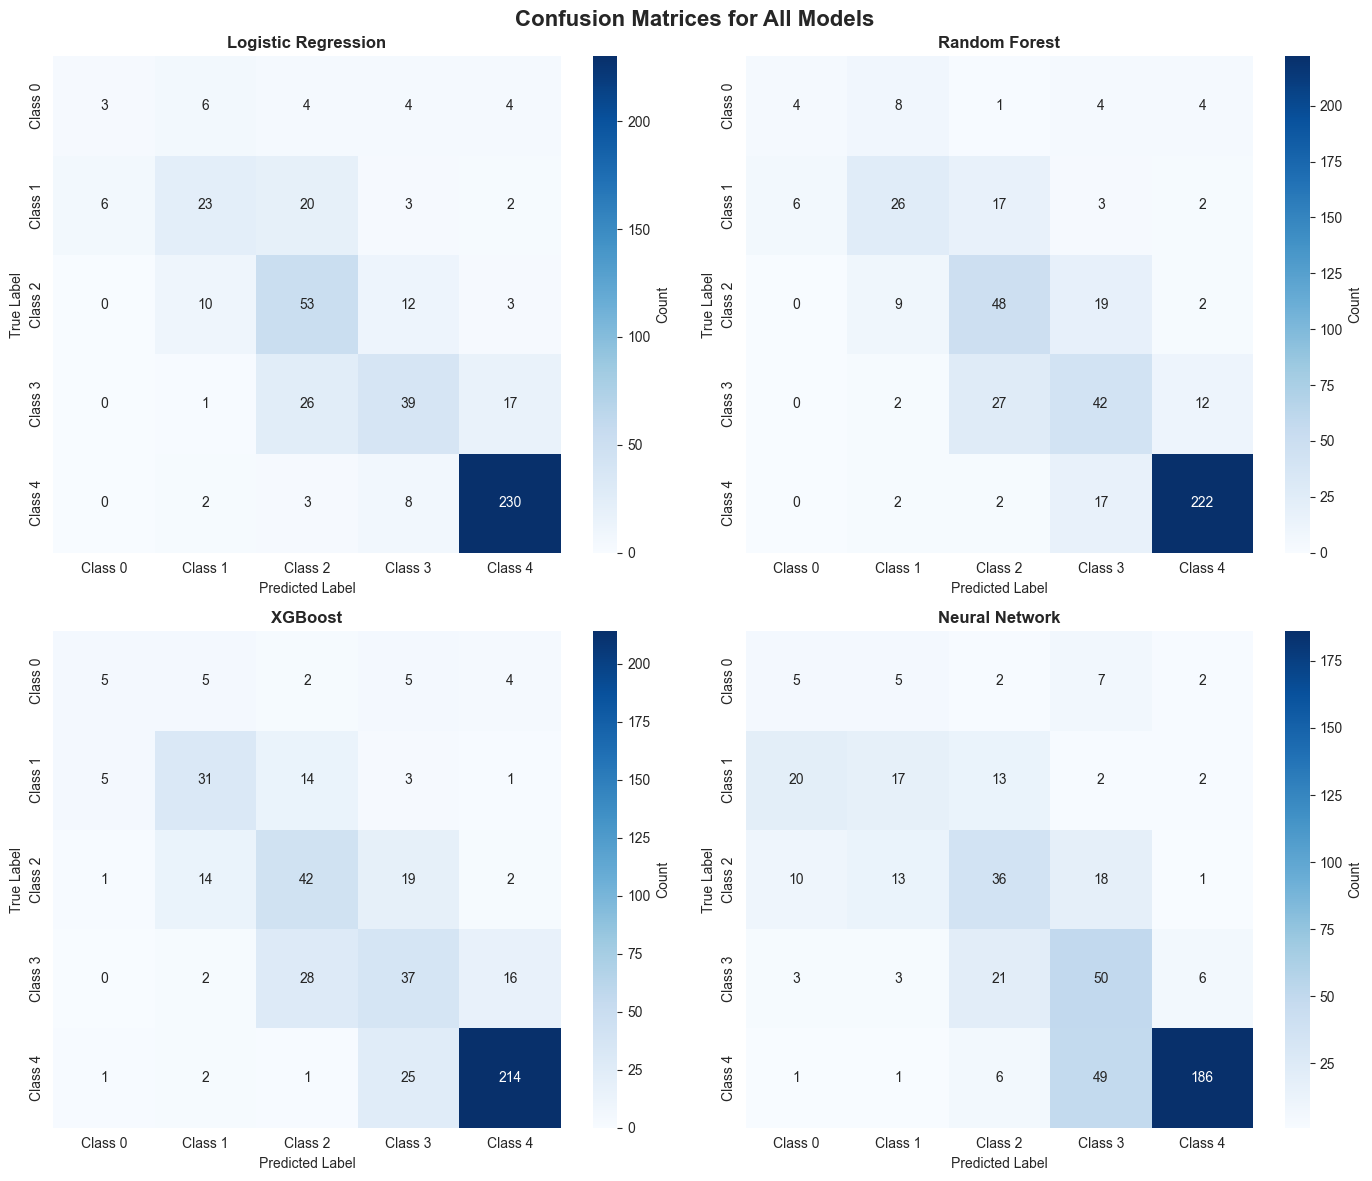

In [36]:
# 2. New confusion matrices
predictions_dict = {
    'Logistic Regression': y_pred_lr,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb,
    'Neural Network': preds.numpy()
}
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']
plot_confusion_matrices(y_test, predictions_dict, class_names)

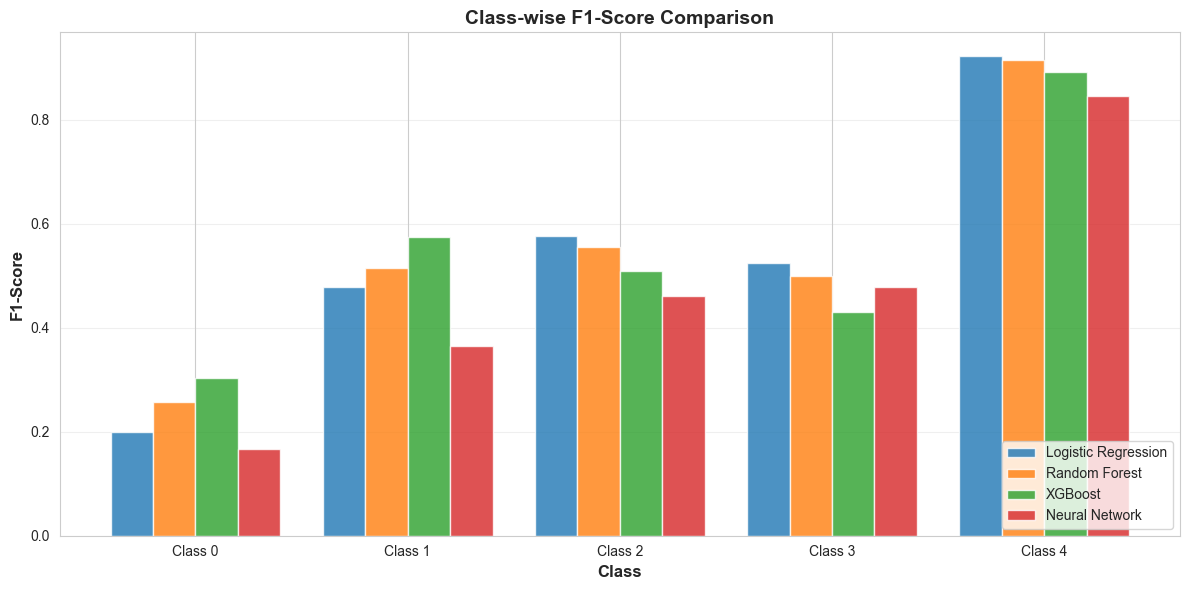

In [37]:
# 3. Class-wise performance
plot_classwise_performance(y_test, predictions_dict, class_names)

After excluding GPA to avoid information leakage and focus on behavioral predictors, overall accuracy and class-wise F1-scores decreased across all models. Interestingly, Logistic Regression achieved the highest accuracy, suggesting that the remaining features exhibit largely linear relationships with student performance. Tree-based models and the neural network experienced a more pronounced performance drop, highlighting their reliance on stronger non-linear signals such as GPA

# 15. Conclusion

In this study, multiple machine learning models were evaluated for predicting student performance in a multi-class classification setting.

Key findings include:
- Tree-based ensemble methods (Random Forest and XGBoost) consistently outperformed linear and neural network models on tabular data
- Handling class imbalance improved class-wise performance, particularly for underrepresented grades
- Neural Networks showed limited performance gains despite tuning, highlighting their sensitivity to tabular datasets
- Removing GPA resulted in reduced accuracy but provided more realistic and interpretable predictions based on student behavior

Overall, this notebook demonstrates a robust and well-structured approach to supervised learning, emphasizing model comparison, fairness, and feature analysis.
